# CMSC320 Final Project
## Regression test of the trend in average GPA of UMD CMSC courses over last two decades
### is there a grade inflation? deflation? or neither?

Group Members: Jihyo Park, Calvin Pham

## Getting the Data & Preprocessing

In [269]:
import requests # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import json

Getting grade data for CMSC from PlanetTerp API. This will give us the list of courses we will further gather detailed yearly data from

In [270]:
# cmsc_data = requests.get(f"https://planetterp.com/api/v1/courses?department=CMSC").json()
# with open('cmsc_data.json', 'w') as f:
#     json.dump(cmsc_data, f)

Preprocessing the data

In [271]:
cmsc_df = pd.read_json('cmsc_data.json')
cmsc_df = cmsc_df.sort_values(by=['course_number'])

# only use 100, 200, 300, and 400 level courses
cmsc_df = cmsc_df[cmsc_df['course_number'].str.startswith(('1','2','3','4'))]

# drop unnecessary columns
cmsc_df.drop(columns=['professors', 'description', 'department', 'is_recent', 'geneds', 'title'], inplace=True)

cmsc_df.dropna(inplace=True)

cmsc_df.drop(cmsc_df[cmsc_df['credits'] < 3.0].index, inplace=True)

cmsc_df.head(10)

,average_gpa,course_number,name,credits
39,2.397251,106,CMSC106,4.0
16,2.527072,122,CMSC122,3.0
40,2.487990,131,CMSC131,4.0
41,2.602482,132,CMSC132,4.0
88,3.365746,132H,CMSC132H,4.0
4,2.471644,216,CMSC216,4.0
11,2.668913,250,CMSC250,4.0
48,3.448966,250H,CMSC250H,4.0
23,2.946301,289I,CMSC289I,3.0
71,3.388555,320,CMSC320,3.0


In [272]:
courses = cmsc_df['name'].values

Getting detailed grade data from PlanetTerp API for each course

In [273]:
# for x in courses:
#     grade_data = requests.get(f"https://api.planetterp.com/v1/grades?course={x}").json()
#     with open(f'./data/{x}.json', 'w') as f:
#         json.dump(grade_data, f)

In [274]:
gpa_map = {
    'A+':   4.0,
    'A':    4.0,
    'A-':   3.7, 
    'B+':   3.3,
    'B':    3.0,
    'B-':   2.7,
    'C+':   2.3,
    'C':    2.0, 
    'C-':   1.7, 
    'D+':   1.3, 
    'D':    1.0, 
    'D-':   0.7, 
    'F':    0.0,
}

grades = gpa_map.keys()
gpas = [gpa_map[grade] for grade in grades]

Preprocessing the data

In [275]:
# build a DataFrame with all course data
df = pd.DataFrame()

for x in courses:
    # we skip honors course in order to combine with non-honors equivalent course
    if x[-1] != 'H':
        grade_data = pd.read_json(f'./data/{x}.json')
        grade_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
        grade_data = grade_data.groupby(['semester']).sum().reset_index()
        grade_data['students'] = grade_data[grades].sum(axis=1)
        grade_data.drop(grade_data[grade_data['students'] == 0].index, inplace=True)
        
        if x + 'H' in courses:
            honors_data = pd.read_json(f'./data/{x}H.json')
            honors_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
            honors_data = honors_data.groupby(['semester']).sum().reset_index()
            honors_data['students'] = honors_data[grades].sum(axis=1)
            grade_data = pd.concat([grade_data,honors_data]).groupby(['semester']).sum().reset_index()
        
        avg_gpa = []
        for index, row in grade_data.iterrows():
            avg_gpa.append(np.dot(row[grades], gpas) / row['students'])
        
        grade_data['avg_gpa'] = avg_gpa
        grade_data.drop(columns=grades, inplace=True)
        grade_data['course'] = x
        grade_data['level'] = int(x[4]) * 100
        
        df = pd.concat([df, grade_data])

df = df.reset_index()
df.drop(columns=['index'], inplace=True)
df.head(20)

,semester,students,avg_gpa,course,level
0,201208,44,2.650000,CMSC106,100
1,201308,49,2.342857,CMSC106,100
2,201408,36,2.961111,CMSC106,100
3,201508,37,2.445946,CMSC106,100
4,201608,42,2.421429,CMSC106,100
5,201708,34,2.588235,CMSC106,100
6,201808,34,2.805882,CMSC106,100
7,201908,38,3.176316,CMSC106,100
8,202008,30,2.736667,CMSC106,100
9,202108,47,3.227660,CMSC106,100


## Plotting

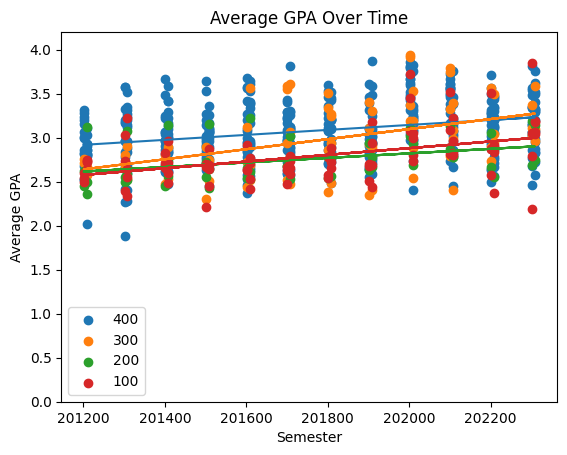

In [276]:
import matplotlib.pyplot as plt  # type: ignore

for level in [400,300,200,100]:
    course_data = df.loc[df["level"] == level]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=level)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend()
plt.ylim(0, 4.2)

plt.show()

/var/folders/w8/2krv1jk52m5_qlhl8fs84ryw0000gn/T/ipykernel_15526/588509130.py:13: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


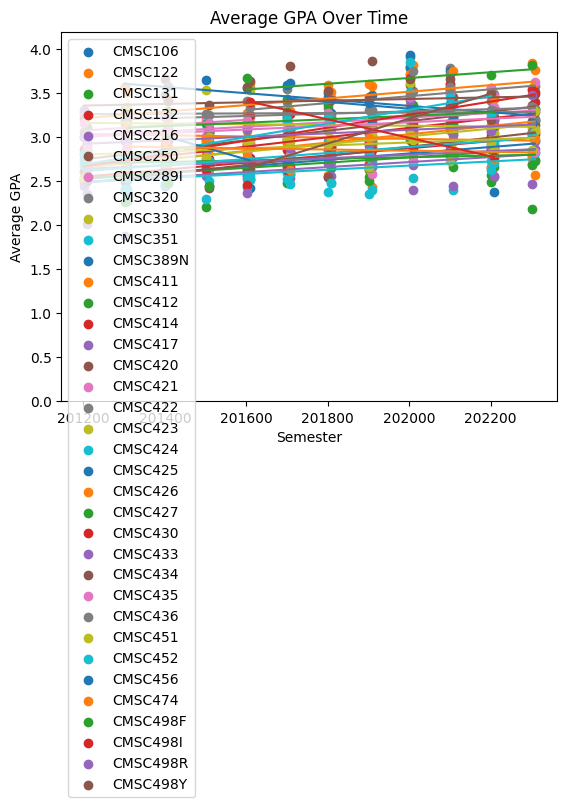

In [277]:
import matplotlib.pyplot as plt  # type: ignore

combined_courses = filter(lambda x : x[-1] != 'H', courses)

for course in combined_courses:
    course_data = df[df["course"] == course]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=course)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend()
plt.ylim(0, 4.2)

plt.show()

## Hypothesis Testing
#### H0: There is no upwards/downwards trend in the average GPA of CMSC courses over time
#### H1: There is a linear trend in the average GPA of CMSC courses over time.
### OLS

In [278]:
import statsmodels.formula.api as smf  # type: ignore
model = smf.ols(formula="avg_gpa ~ semester", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     72.19
Date:                Wed, 15 May 2024   Prob (F-statistic):           1.38e-16
Time:                        00:48:21   Log-Likelihood:                -208.98
No. Observations:                 640   AIC:                             422.0
Df Residuals:                     638   BIC:                             430.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -64.2900      7.920     -8.117      0.0

In [279]:
import statsmodels.formula.api as smf  # type: ignore
model = smf.ols(formula="avg_gpa ~ semester * C(level)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     26.26
Date:                Wed, 15 May 2024   Prob (F-statistic):           1.24e-31
Time:                        00:49:09   Log-Likelihood:                -161.60
No. Observations:                 640   AIC:                             339.2
Df Residuals:                     632   BIC:                             374.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               